In [57]:
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from fairlearn.metrics import MetricFrame

from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)


from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

In [88]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2

In [89]:
fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [60]:
X_train = np.array([[0., 0., 1.], [0., 1., 1.], [0., 0., 0.]])
y_train = np.array([0, 1, 0])
A_train = np.array([0, 1, 0])

In [61]:
X_test = np.array([[0., 0., 1.], [0., 1., 1.], [0., 0., 0.]])
y_test = np.array([0, 1, 0])
A_test = np.array([0, 1, 0])

### Regular Model

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [78]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [81]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.7075
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7065
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7056
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7047
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7038
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7029
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7021
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 0.7012
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7003
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.6994


In [103]:
Y_pred = (model.predict(X_test) >= 0.5).astype(int)
Y_pred

1/1 [==============================] - 0s 10ms/step


array([[1],
       [1],
       [0]])

In [104]:
## Print Balanced Accuracy
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
balanced_accuracy_unmitigated

0.75

In [106]:
## Print Equalized Odds score
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)
equalized_odds_unmitigated

1.0

### Fair Model

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [64]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X, y, A
):
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    Predictors
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X, y, sensitive_features=A)
    predictors = exp_grad_est.predictors_
    return predictors

In [65]:
epsilons = [0.01, 0.02]
estimator=model

In [66]:
### Needed modification to FairLearn Source Code
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X=X_train,
        y=y_train,
        A=A_train,
    )

1/1 [==============================] - 0s 8ms/step


In [67]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 5 inner models
For epsilon 0.02, ExponentiatedGradient learned 3 inner models


### Inner Model Analysis

In [68]:
def is_pareto_efficient(points):
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [69]:
def filter_dominated_rows(points):
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]


In [45]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List of performance scores for each classifier in predictors, for the
    given metric.
    """
    all_predictions = [predictor.predict(X_test) > 0.5 for predictor in predictors]
    if A_test is not None:
        print(all_predictions)
        print(Y_test)
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [70]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    DataFrame where each row represents a model (epsilon, index) and its
    performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [71]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

1/1 [==============================] - 0s 8ms/step
[array([[ True],
       [False],
       [False]]), array([[ True],
       [ True],
       [False]]), array([[False],
       [False],
       [ True]]), array([[False],
       [ True],
       [False]]), array([[ True],
       [ True],
       [False]])]
[0 1 0]
1/1 [==============================] - 0s 8ms/step
[array([[ True],
       [ True],
       [False]]), array([[False],
       [ True],
       [False]]), array([[ True],
       [ True],
       [False]])]
[0 1 0]
1/1 [==============================] - 0s 7ms/step


In [72]:
performance_subset = performance_df.loc[
    :, ["equalized_odds", "balanced_error"]
]

In [73]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]

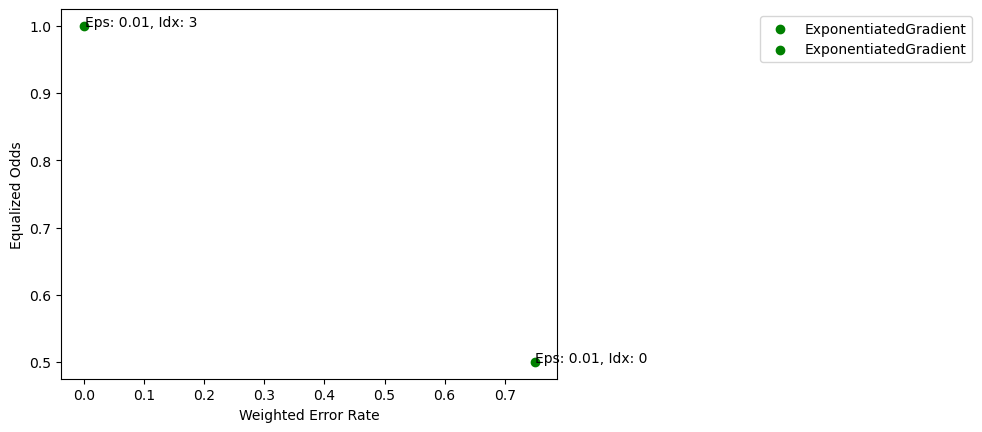

In [74]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
#plt.scatter(
#    1.0 - balanced_accuracy_unmitigated,
#    equalized_odds_unmitigated,
#    label="UnmitigatedModel",
#)
#plt.scatter(
#    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
#)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))

### Select Best Model

In [75]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [107]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.01, Index number: 1.0


In [109]:
y_pred_inprocess = (inprocess_model.predict(X_test) > 0.5)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)

1/1 [==============================] - 0s 11ms/step


In [111]:
## Print Balanced Accuracy
balanced_accuracy_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
balanced_accuracy_inprocess

0.75

In [ ]:
## Print Equalized Odds score
equalized_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)
equalized_odds_inprocess